In [1]:
%load_ext autoreload
%autoreload 2

In [2]:

from toss import compute_trajectory
from toss import compute_motion, setup_spin_axis
from toss import get_trajectory_fixed_step
from toss import FitnessFunctions
from toss import get_fitness
from toss import create_mesh

from dotmap import DotMap
import numpy as np
from math import pi
import matplotlib.pyplot as plt 


Using numpy backend


In [3]:

def get_parameters():
    """Returns parameters used by compute trajectory and fitness functions.

    Returns:
        args (dotmap.Dotmap): Dotmap with parameters used for the tests.
    """
    args = DotMap(
        body = DotMap(_dynamic=False),
        integrator = DotMap(_dynamic=False),
        problem = DotMap(_dynamic=False),
        mesh = DotMap(_dynamic=False),
        _dynamic=False)

    # Setup body parameters
    args.body.density = 533                  # https://sci.esa.int/web/rosetta/-/14615-comet-67p
    args.body.mu = 665.666                   # Gravitational parameter for 67P/C-G
    args.body.declination = 64               # [degrees] https://sci.esa.int/web/rosetta/-/14615-comet-67p
    args.body.right_ascension = 69           # [degrees] https://sci.esa.int/web/rosetta/-/14615-comet-67p
    args.body.spin_period = 12.06*3600       # [seconds] https://sci.esa.int/web/rosetta/-/14615-comet-67p
    args.body.spin_velocity = (2*pi)/args.body.spin_period
    args.body.spin_axis = setup_spin_axis(args)

    # Setup specific integrator parameters:
    args.integrator.algorithm = 3
    args.integrator.dense_output = True
    args.integrator.rtol = 1e-12
    args.integrator.atol = 1e-12

    # Setup problem parameters
    args.problem.start_time = 0                     # Starting time [s]
    args.problem.final_time = 2419200             # Final time [s]
    args.problem.initial_time_step = 1            # Initial time step size for integration [s]
    args.problem.activate_event = True              # Event configuration (0 = no event, 1 = collision with body detection)
    args.problem.number_of_maneuvers = 1 
    args.problem.target_squared_altitude = 4000**2  # Target altitude squared [m]
    args.problem.activate_rotation = True
    args.problem.penalty_scaling_factor = 0.1
    args.problem.max_velocity_scaling_factor = 40
    args.problem.number_of_spacecrafts = 1


    # Arguments concerning bounding spheres
    args.problem.measurement_period = 100                # Period for when a measurement sphere is recognized and managed. Unit: [seconds]
    args.problem.radius_inner_bounding_sphere = 4000      # Radius of spherical risk-zone for collision with celestial body [m]
    args.problem.radius_outer_bounding_sphere = 15000
    args.problem.squared_volume_inner_bounding_sphere = (4/3) * pi * (args.problem.radius_inner_bounding_sphere**3)
    args.problem.squared_volume_outer_bounding_sphere = (4/3) * pi * (args.problem.radius_outer_bounding_sphere**3)
    args.problem.measurable_volume = args.problem.squared_volume_outer_bounding_sphere - args.problem.squared_volume_inner_bounding_sphere

    args.problem.maximal_measurement_sphere_volume = (4/3) * pi * (35.95398913**3)

    # Create mesh of body.
    args.mesh.body, args.mesh.vertices, args.mesh.faces, args.mesh.largest_body_protuberant = create_mesh("3dmeshes/churyumov-gerasimenko_lllp.pk")

    return args

In [4]:
args = get_parameters()
#x = [9.16234255e+03, 1.73917660e-02, 3.03363317e+00, 3.57741462e+00, 5.49214728e+00, 4.73909083e+00]
#x = [8.76679448e+03, 2.20679992e-02, 1.24754326e+00, 3.86373567e+00, 2.99297042e+00, 2.82755377e+00] #[9.24065403e+03, 3.28556596e-02, 1.96795951e+00, 4.55936911e+00, 3.26872264e+00, 2.30312127e+00]
x = np.genfromtxt('champion_x.csv', delimiter=',')
#x = np.hstack((np.array([1.02346115e+04, 5.04262474e-01, 1.40521347e+00, 3.03148072e+00, 2.68878957e-01, 5.74690265e+00]), x))
#x = [5.24536306e+03, 2.04196908e-01, 1.58144741e+00, 4.82484233e+00, 1.24961743e+00, 2.56597493e-01]
_, list_of_ode_pbjects, _ = compute_trajectory(x, args, compute_motion)
positions, velocities, timesteps = get_trajectory_fixed_step(args, list_of_ode_pbjects)

fitness_func = [FitnessFunctions.TargetAltitudeDistance, FitnessFunctions.CloseDistancePenalty, FitnessFunctions.FarDistancePenalty, FitnessFunctions.CoveredSpace, FitnessFunctions.CoveredSpaceCloseDistancePenaltyFarDistancePenalty]
scaled_positions = np.empty((3*len(fitness_func), len(timesteps)), dtype=np.float64)
fitness_perturbation = np.arange(0,3,0.1)

fitness_array = np.empty((len(fitness_func), len(fitness_perturbation)))

for func_counter, func in enumerate(fitness_func):
    for perturb_counter, perturbation in enumerate(fitness_perturbation): # or some sensible range, you choose
        scaled_pos = perturbation*positions
        fitness = get_fitness(func, args, scaled_pos, velocities, timesteps)
        fitness_array[func_counter, perturb_counter] = fitness
       

In [213]:
args = get_parameters()
x = np.genfromtxt('champion_x.csv', delimiter=',')

# Separate each chromosome representing an induvidual spacecraft:
list_of_spacecrafts = np.array_split(x, args.problem.number_of_spacecrafts)

# Resample and store trajectory for each spacecraft with a fixed time-step delta t
positions = None
velocities = None
timesteps = None

for counter, spacecraft in enumerate(list_of_spacecrafts):

    # Compute trajectory
    collision_detected, list_of_ode_objects, _ = compute_trajectory(spacecraft, args, compute_motion)
    
    # Resample trajectory for a fixed time-step delta t
    spacecraft_positions, spacecraft_velocities, spacecraft_timesteps = get_trajectory_fixed_step(args, list_of_ode_objects)

    # Store information
    if counter == 0:
        positions = spacecraft_positions
        velocities = spacecraft_velocities
        timesteps = spacecraft_timesteps

    else:
        positions = np.vstack((positions, spacecraft_positions))
        velocities = np.vstack((velocities, spacecraft_velocities))



In [12]:
# Compute aggregate fitness:
chosen_fitness_function = FitnessFunctions.CoveredSpace
fitness = get_fitness(chosen_fitness_function, args, positions, velocities, timesteps)

print(fitness)

0.052521008403361345


In [41]:
import numpy as np
print(np.max(np.abs(velocities[0,:])))
print(np.max(np.abs(velocities[1,:])))
print(np.max(np.abs(velocities[2,:])))

print(np.where(velocities[2,:]==float(-1.035379671417797)))
print(positions[:,719])


0.3963149915261681
0.7419655892463498
1.035379671417797
(array([719]),)
[ -5800.03582587  -5843.73157847 -11775.21169706]


[Text(0.5, 0, 'Scaling factor'),
 Text(0, 0.5, 'Fitness'),
 Text(0.5, 1.0, 'CoveredSpaceCloseDistancePenaltyFarDistancePenalty')]

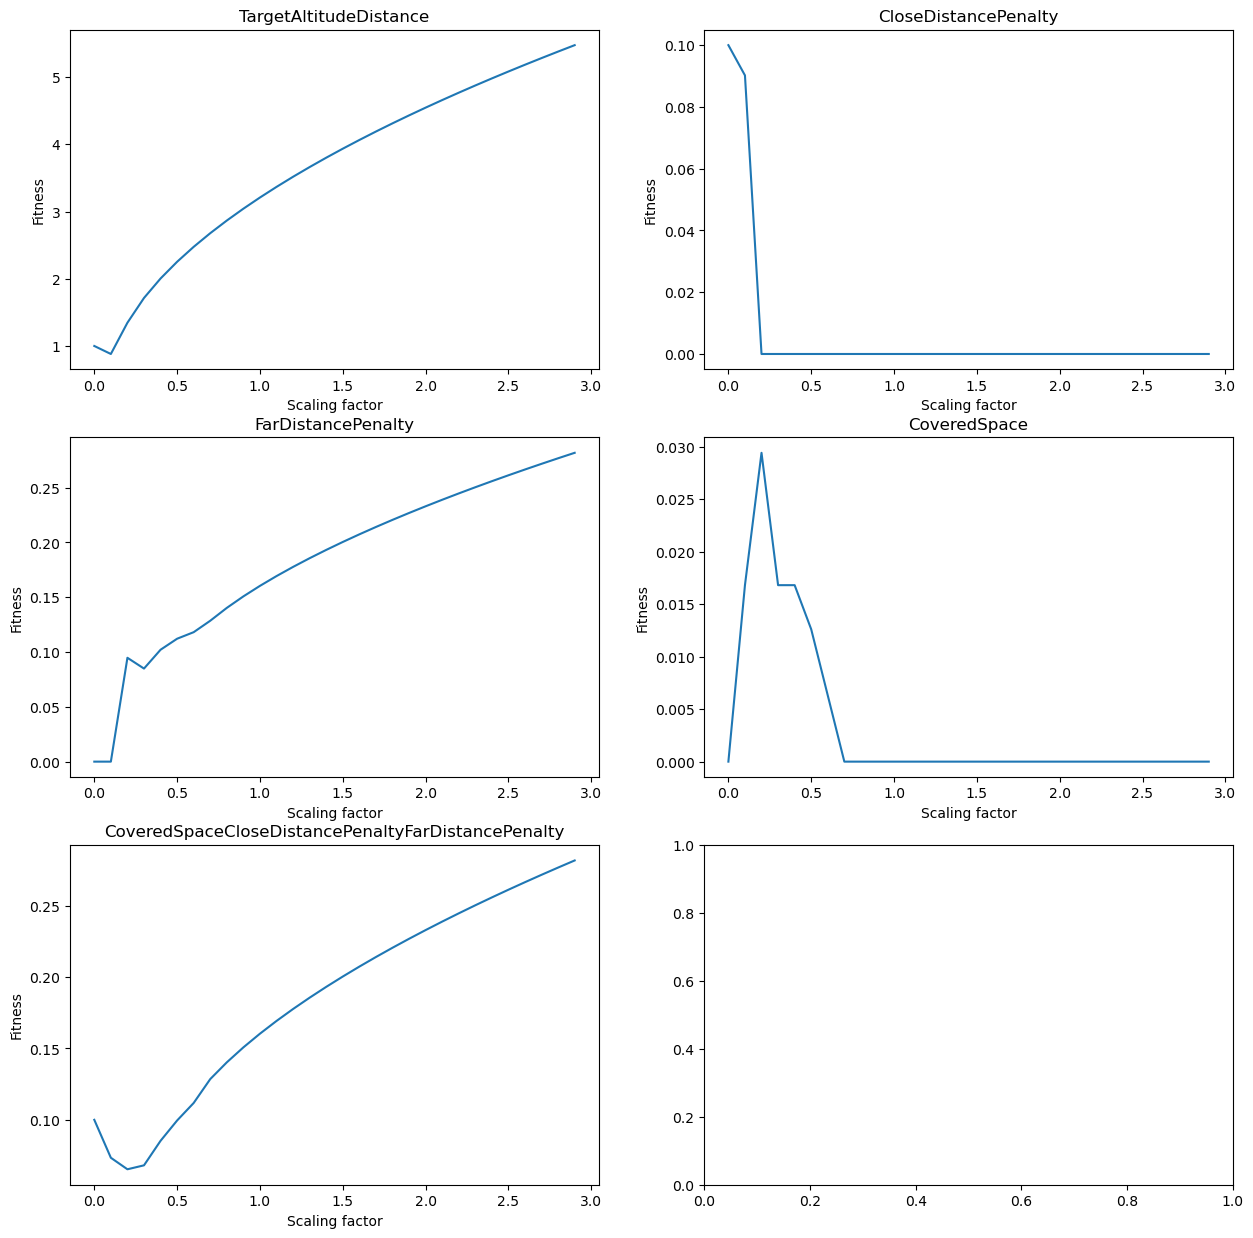

In [5]:


fig, axes = plt.subplots(3,2)
fig.set_figheight(15)
fig.set_figwidth(15)

axes[0,0].plot(fitness_perturbation, fitness_array[0,:])
axes[0,0].set(xlabel='Scaling factor', ylabel='Fitness',
       title='TargetAltitudeDistance')

axes[0,1].plot(fitness_perturbation, fitness_array[1,:])
axes[0,1].set(xlabel='Scaling factor', ylabel='Fitness',
       title='CloseDistancePenalty')

axes[1,0].plot(fitness_perturbation, fitness_array[2,:])
axes[1,0].set(xlabel='Scaling factor', ylabel='Fitness',
       title='FarDistancePenalty')

axes[1,1].plot(fitness_perturbation, fitness_array[3,:])
axes[1,1].set(xlabel='Scaling factor', ylabel='Fitness',
       title='CoveredSpace')

axes[2,0].plot(fitness_perturbation, fitness_array[4,:])
axes[2,0].set(xlabel='Scaling factor', ylabel='Fitness',
       title='CoveredSpaceCloseDistancePenaltyFarDistancePenalty')


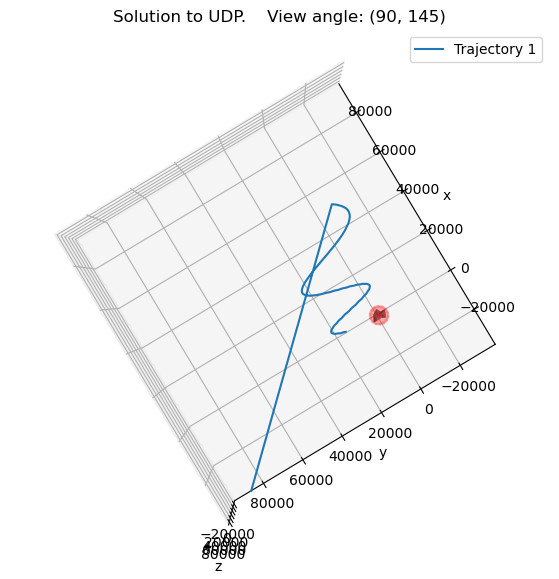

In [6]:
from toss import plot_UDP
#args = get_parameters()
#x = [9.16234255e+03, 1.73917660e-02, 3.03363317e+00, 3.57741462e+00, 5.49214728e+00, 4.73909083e+00]
#x = np.genfromtxt('champion_x.csv', delimiter=',')[14:]

#_, list_of_ode_pbjects, _ = compute_trajectory(x, args, compute_motion)
#positions, velocities, timesteps = get_trajectory_fixed_step(args, list_of_ode_pbjects)

plot_UDP(args, positions, True, True, True, False, [90,145], None)



In [194]:
import pykep as pk
from toss import plot_UDP
from toss import get_trajectory_adaptive_step

# Setup problem parameters
args = get_parameters()
args.problem.start_time = 0                    
args.problem.final_time = 20000            
args.problem.number_of_maneuvers = 0 
args.problem.activate_rotation = True
args.problem.number_of_spacecrafts = 1
args.problem.measurement_period = 10              
args.problem.radius_inner_bounding_sphere = 4000      
args.problem.radius_outer_bounding_sphere = 15000

# Assign initial velocity
x = np.empty(6, dtype=np.float64)
x[0:3] = [5500, 0, 0]
x[3:6] = [0.1, -0.1, -0.3] # velocity that works: [0.44, 0.35, 0.4]

# Convert to osculating elements
x = pk.ic2par(r=x[0:3], v=x[3:6], mu=args.body.mu)
_, list_of_ode_pbjects, _ = compute_trajectory(x, args, compute_motion)
#positions, velocities, timesteps = get_trajectory_fixed_step(args, list_of_ode_pbjects)
states, timesteps = get_trajectory_adaptive_step(list_of_ode_pbjects)
positions = states[0:3, :]

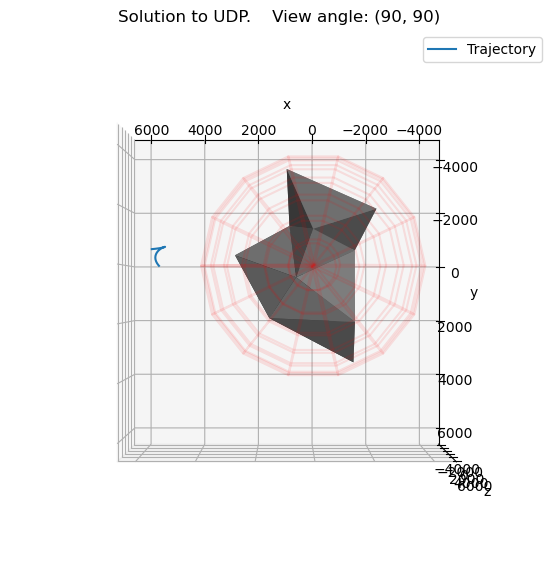

In [195]:
plot_UDP(args, positions, True, True, True, False, [90,90], None)

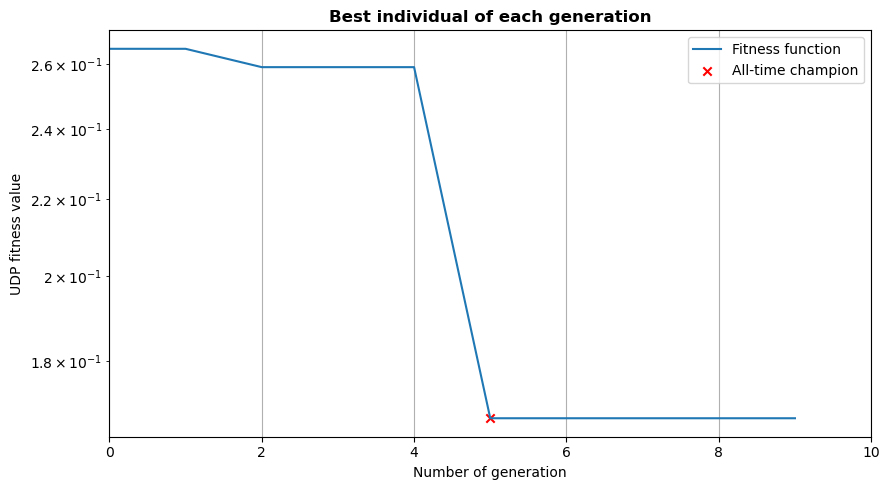

In [7]:
from toss import fitness_over_generations
import numpy as np 
fitness_list = np.genfromtxt('fitness_list.csv', delimiter=',')
n_generations = 10

fitness_over_generations(fitness_list, n_generations)

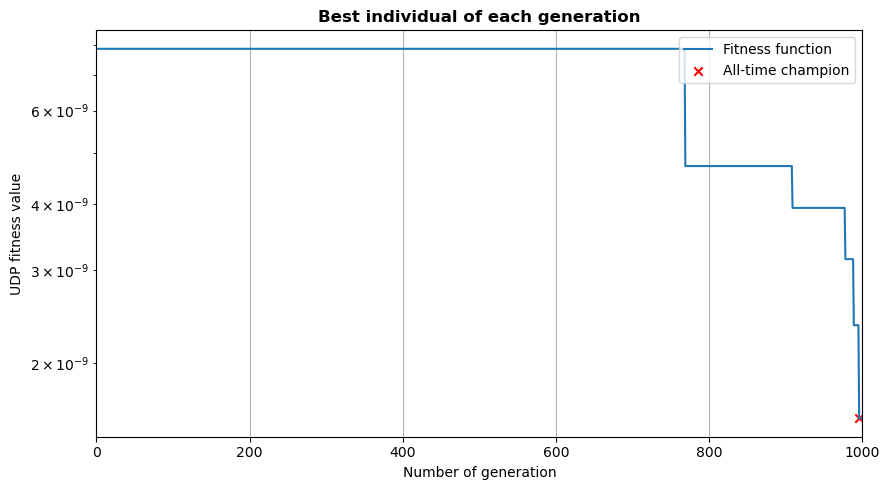

In [22]:
import numpy as np
fitness_list = np.genfromtxt
fitness_over_generations(np.flip(-1*fitness_list), n_generations)

[-4.71395750e-09 -7.85659584e-09 -7.85659584e-09]
